### Step 1: Import Required Libraries

- **pandas** → for data cleaning, manipulation, and reading CSV files  
- **tifffile** → to read multispectral satellite images (`.tif` files)  
- **numpy** → for numerical operations and handling image arrays/tensors  
- **matplotlib** → for visualizing images and plots  
- **fastai** → for deep learning and training models easily


In [1]:
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
from fastai.vision.all import *

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### Step 2: Load csv files

In [2]:
base_path = "/kaggle/input/eurosat-dataset/EuroSATallBands"

train_df = pd.read_csv(base_path + "/train.csv")
val_df   = pd.read_csv(base_path + "/validation.csv")
test_df  = pd.read_csv(base_path + "/test.csv")

### Step 3: Just check the traind dataset

In [3]:
train_df.head()

,Filename,Label,ClassName
0,PermanentCrop/PermanentCrop_2401.tif,6,PermanentCrop
1,PermanentCrop/PermanentCrop_1006.tif,6,PermanentCrop
2,HerbaceousVegetation/HerbaceousVegetation_1025.tif,2,HerbaceousVegetation
3,SeaLake/SeaLake_1439.tif,9,SeaLake
4,River/River_1052.tif,8,River


### Step 4: Make sure whether the dataset is complete without null values

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19317 entries, 0 to 19316
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   19317 non-null  object
 1   Label      19317 non-null  int64 
 2   ClassName  19317 non-null  object
dtypes: int64(1), object(2)
memory usage: 452.9+ KB


### Step 5: The dataset contains 19317, 3 shape

In [5]:
train_df.shape

(19317, 3)

### Step 6: Check the how many rows with each unique 'Label'

In [6]:
train_df['Label'].value_counts()

Label
9    2517
2    2100
0    2100
1    2100
7    2100
6    1750
8    1750
3    1750
4    1750
5    1400
Name: count, dtype: int64

### Step 7: Convert the sattelite images to three channel RGB images

(64, 64, 13)


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

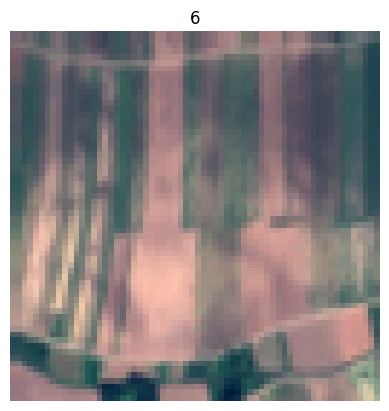

In [7]:
row = train_df.iloc[0]

img_path = base_path + "/" + row['Filename']
label = row['Label']

img = tiff.imread(img_path)

print(img.shape)
rgb = img[:, :, [3, 2, 1]]

rgb = rgb.astype(float)
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.imshow(rgb)
plt.title(label)
plt.axis("off")

### Step 8: Look at the Validation dataset

In [8]:
val_df.head()

,Filename,Label,ClassName
0,Residential/Residential_1716.tif,7,Residential
1,Residential/Residential_735.tif,7,Residential
2,SeaLake/SeaLake_2384.tif,9,SeaLake
3,AnnualCrop/AnnualCrop_2534.tif,0,AnnualCrop
4,PermanentCrop/PermanentCrop_1363.tif,6,PermanentCrop


### Step 9: Look at the test dataset

In [9]:
test_df.head()

,Filename,Label,ClassName
0,HerbaceousVegetation/HerbaceousVegetation_2000.tif,2,HerbaceousVegetation
1,HerbaceousVegetation/HerbaceousVegetation_514.tif,2,HerbaceousVegetation
2,Residential/Residential_597.tif,7,Residential
3,River/River_2122.tif,8,River
4,SeaLake/SeaLake_2747.tif,9,SeaLake


### Step 10: Create a function to get the sattelite images and convert them to RGB images and return them which will be used in the DataBlock 

In [10]:
import warnings
from pydantic import warnings as pyd_warnings

warnings.filterwarnings("ignore", category=pyd_warnings.UnsupportedFieldAttributeWarning)

def open_tif_rgb(fn):
    img = tiff.imread(fn)  # read multi-band TIFF

    # select RGB bands (4,3,2)
    rgb = img[:, :, [3,2,1]]

    # normalize to 0-1
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    # convert to uint8 and create fastai PILImage
    return PILImage.create((rgb*255).astype(np.uint8))

### Step 11: Create a DataBlock

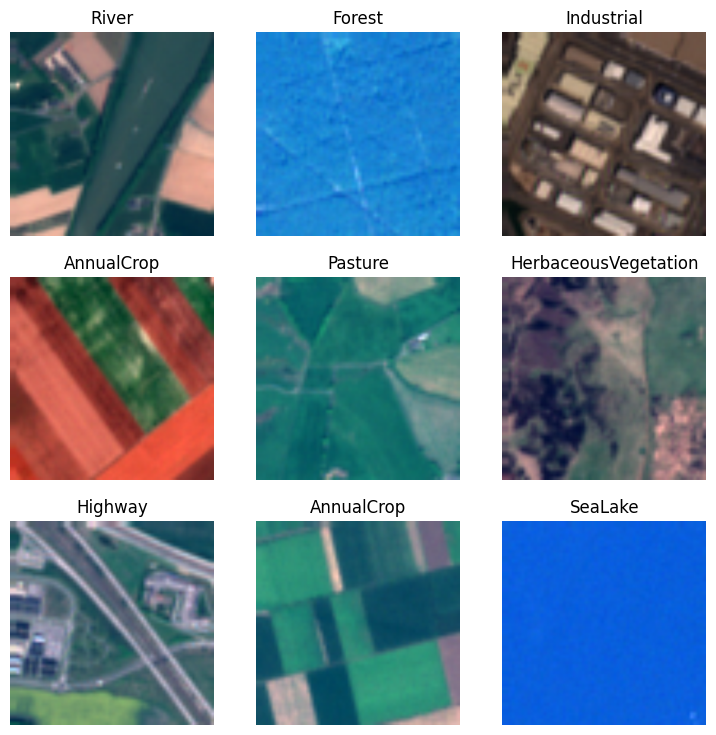

In [11]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=open_tif_rgb,            
    get_y=lambda r: r.parent.name,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(224)
)

dls = dblock.dataloaders(get_image_files(base_path), bs=32)
dls.show_batch(max_n=9)

### Step 12: Use the pre-trained model to fine tune it

In [12]:

learn = vision_learner(dls, resnet18, metrics=accuracy)

learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.429969,0.258684,0.915746,01:17


epoch,train_loss,valid_loss,accuracy,time
0,0.190465,0.086426,0.968110,01:17


### Step 2: Check the model performance by taking the samples from the test dataset

In [19]:
row = test_df.iloc[65]
img = open_tif_rgb(base_path + "/" + row['Filename'])

pred, pred_idx, probs = learn.predict(img)

print("Predicted:", pred)
print("Actual:", row['ClassName'])

Predicted: Industrial
Actual: Industrial
